# Data pre-processing

In [ ]:
import os
import random
import datetime
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa
import torch
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Activation, Flatten, Dense, Dropout, ReLU, GlobalAveragePooling2D, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
# set random seeds
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# If using GPU and PyTorch
if torch.cuda.is_available():
   torch.cuda.manual_seed_all(42)

In [ ]:
def isolator(signal, sample_rate, size, scan, before, after, threshold, show=False):
    """
    This function isolates segments of an audio signal that exceed a specified energy threshold.

    Parameters:
    - signal (np.array): The input audio signal.
    - sample_rate (int): The sample rate of the audio signal.
    - size (int): The window size for the FFT (Fast Fourier Transform).
    - scan (int): The hop length for the FFT, which determines the stride of the sliding window.
    - before (int): Number of samples to include before the threshold crossing.
    - after (int): Number of samples to include after the threshold crossing.
    - threshold (float): The energy level that must be exceeded to trigger isolation.
    - show (bool): If True, displays plots of the waveform during various processing stages.

    Returns:
    - strokes (list): A list of isolated audio segments, each as a PyTorch tensor.
    """
    strokes = []

    # Display the original waveform if requested
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(signal, sr=sample_rate)

    # Compute the short-time Fourier transform to analyze frequency components
    fft = librosa.stft(signal, n_fft=size, hop_length=scan)
    # Calculate total energy across frequencies at each time point
    energy = np.abs(np.sum(fft, axis=0)).astype(float)

    # Plot the energy waveform if visualization is enabled
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(energy, sr=sample_rate)

    # Threshold the energy to find significant events
    threshed = energy > threshold

    # Display the thresholded energy as a binary waveform for visualization
    if show:
        plt.figure(figsize=(7, 2))
        librosa.display.waveshow(threshed.astype(float), sr=sample_rate)

    # Detect indices where the energy exceeds the threshold
    peaks = np.where(threshed == True)[0]
    peak_count = len(peaks)
    prev_end = sample_rate * 0.1 * (-1)

    # Iterate over detected peaks and isolate segments according to the threshold
    for i in range(peak_count):
        this_peak = peaks[i]
        timestamp = (this_peak * scan) + size // 2
        # Ensure that segments do not overlap by checking the interval since the last segment
        if timestamp > prev_end + (0.1 * sample_rate):
            keystroke = signal[timestamp - before : timestamp + after]
            strokes.append(torch.tensor(keystroke)[None, :])
            # Plot the isolated keystroke waveform if visualization is enabled
            if show:
                plt.figure(figsize=(7, 2))
                librosa.display.waveshow(keystroke, sr=sample_rate)
            prev_end = timestamp + after

    return strokes

def add_gaussian_noise(signal, noise_factor=0.001):
    """
    This function introduces Gaussian noise to an audio signal.

    Parameters:
    - signal: The input audio signal array.
    - noise_factor: A coefficient to control the amplitude of the noise.

    Returns:
    - Noisy signal.
    """
    noise = np.random.randn(len(signal))
    return signal + noise_factor * noise

def time_shift(signal, sample_rate, shift_max=0.1):
    """
    Randomly shifts the signal in time either forwards or backwards.

    Parameters:
    - signal: The input audio signal array.
    - sample_rate: The sample rate of the audio signal.
    - shift_max: Maximum proportion of the signal length to shift.

    Returns:
    - Time-shifted audio signal.
    """
    shift = np.random.randint(int(shift_max * sample_rate))
    return np.roll(signal, shift)

def time_mask(signal, sample_rate, mask_duration=0.1):
    """
    Applies a time mask to the audio signal. A segment of the audio is set to zero.

    Parameters:
    - signal: The input audio signal array.
    - sample_rate: The sample rate of the audio signal.
    - mask_duration: Maximum duration of the mask as a fraction of the total signal length.

    Returns:
    - Masked audio signal.
    """
    duration = len(signal)
    mask_length = int(mask_duration * duration)

    # Ensure mask_length does not exceed duration
    if mask_length >= duration:
        mask_length = max(0, duration - 1)  # Ensure it's at least 0

    # Proceed only if there is room to apply a mask
    if mask_length > 0:
        start = np.random.randint(0, duration - mask_length)
        signal[start:start + mask_length] = 0

    return signal


def frequency_mask(signal, sample_rate, frequency_width=0.1):
    """
    Applies a random frequency mask to a portion of the signal to simulate the effect
    of some frequencies being drowned out or lost.

    Parameters:
    - signal: The input audio signal array.
    - sample_rate: The sample rate of the audio signal.
    - frequency_width: Proportion of frequencies to mask.

    Returns:
    - The frequency-masked signal.
    """
    S = librosa.stft(signal)
    num_freqs = S.shape[0]
    f0 = np.random.uniform(0, num_freqs - frequency_width * num_freqs)
    f0 = int(f0)
    S[f0:f0 + int(frequency_width * num_freqs), :] = 0
    return librosa.istft(S)

def plot_spectrogram(S_DB, sr, title, show_plots):
    """
    Generates and displays a spectrogram of the audio signal. It’s useful for visual
    inspection of the frequency components.

    Parameters:
    - S_DB: Decibel levels from the Mel-spectrogram.
    - sr: Sample rate of the original audio signal.
    - title: Title for the plot.
    - show_plots: Boolean to control the display of the plot.
    """
    if show_plots:
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(S_DB, sr=sr, hop_length=128, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()
        plt.show()

def process_audio_files(show_plots=True, num_augmented_versions=2, fft_size=4096, hop_length=128, before_ratio=0.1, after_ratio=0.4, threshold=0.5):
    """
    Processes audio files from a specified directory, extracts segments using an isolation function,
    generates both original and noisy spectrograms, and optionally displays them.

    Parameters:
    - show_plots: Boolean to control the display of spectrograms.
    - num_augmented_versions: Number of noisy versions to generate for each original stroke.
    - fft_size: The window size for the Fourier transform.
    - hop_length: Number of samples between successive frames.
    - before_ratio: Ratio of the sample rate to define the segment before the peak.
    - after_ratio: Ratio of the sample rate to define the segment after the peak.
    - threshold: Energy threshold for detecting peaks in the audio signal.

    This function navigates through a designated folder, processes each '.wav' file found,
    and stores spectrogram data for further analysis or training.
    """
    for filename in os.listdir(audio_folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(audio_folder_path, filename)
            signal, sample_rate = librosa.load(file_path, sr=None)
            duration = librosa.get_duration(y=signal, sr=sample_rate)
            # Prepare signal by trimming and appending silence
            signal = signal[int(sample_rate):int(duration * sample_rate) - int(sample_rate)]
            silence = np.zeros(sample_rate)  # Append silence to avoid edge effects
            signal = np.concatenate((signal, silence))

            # Define parameters for isolation function based on the sample rate
            before = int(before_ratio * sample_rate)
            after = int(after_ratio * sample_rate)

            # Extract strokes from the audio signal
            strokes = isolator(signal, sample_rate, fft_size, hop_length, before, after, threshold, show=False)

            # Process each isolated stroke and generate spectrograms
            for i, stroke_tensor in enumerate(strokes):
                if i >= 25:  # Limit processing to prevent excessive computation
                    break
                stroke = stroke_tensor.detach().numpy().flatten()

                # Create the original Mel-spectrogram
                S_original = librosa.feature.melspectrogram(y=stroke, sr=sample_rate, n_fft=fft_size, hop_length=hop_length)
                S_DB_original = librosa.power_to_db(S_original, ref=np.max)

                # Generate augmented (noisy) versions of the spectrogram
                for _ in range(num_augmented_versions):

                    # Add Gaussian noise
                    augmented_signal = add_gaussian_noise(stroke)
                    # Time shift
                    augmented_signal = time_shift(augmented_signal, sample_rate)
                    # Time mask
                    augmented_signal = time_mask(augmented_signal, sample_rate)
                    # Frequency mask
                    augmented_signal = frequency_mask(augmented_signal, sample_rate)

                    S_augmented = librosa.feature.melspectrogram(y=augmented_signal, sr=sample_rate, n_fft=fft_size, hop_length=hop_length)
                    S_DB_augmented = librosa.power_to_db(S_augmented, ref=np.max)
                    X_noisy.append(S_DB_augmented)

                    # Store the clean spectrogram and label for each noisy version
                    X_clean.append(S_DB_original.copy())
                    labels.append(filename.split('.')[0])

                    # Optionally display the generated spectrograms
                    if show_plots:
                        plot_spectrogram(S_DB_original, sample_rate, f"Original Mel Spectrogram of {filename} - Stroke {i}", True)
                        plot_spectrogram(S_DB_augmented, sample_rate, f"Noisy Mel Spectrogram of {filename} - Stroke {i}", True)

def pad_spectrogram(spectrogram, target_shape=(180, 180)):
    """
    This function pads a spectrogram to a specified target shape.

    Parameters:
    - spectrogram (np.array): The input spectrogram array to be padded.
    - target_shape (tuple): The desired shape (height, width) of the output padded spectrogram.

    Returns:
    - padded_spectrogram (np.array): The spectrogram padded to the target shape with zeros.
    """
    # Calculate the padding needed for height and width
    pad_height = max(target_shape[0] - spectrogram.shape[0], 0)
    pad_width = max(target_shape[1] - spectrogram.shape[1], 0)

    # Determine padding for top and bottom to center the spectrogram vertically
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top

    # Determine padding for left and right to center the spectrogram horizontally
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    # Apply padding to the spectrogram and return the result
    padded_spectrogram = np.pad(
        spectrogram,
        pad_width=((pad_top, pad_bottom), (pad_left, pad_right)),
        mode='constant',  # Specify the padding mode as constant
        constant_values=0  # Set the value used for padding to zero
    )
    return padded_spectrogram



## MBPWavs

In [ ]:
audio_folder_path = 'MBPWavs'
X_noisy = []
X_clean = []
labels = []
process_audio_files(show_plots=False)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=4096 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=4096 is too large for input signal of length=0
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


In [ ]:
print(len(X_noisy), len(X_clean), len(labels))

1730 1730 1730


In [ ]:
# Split training/test set

X_noisy_padded = np.array([pad_spectrogram(spec) for spec in X_noisy])
X_clean_padded = np.array([pad_spectrogram(spec) for spec in X_clean])

# Combine noisy and clean datasets
X_combined = np.vstack((X_noisy_padded, X_clean_padded))

# Duplicate labels twice
labels_doubled = np.tile(labels, 2)

# Process labels
label_encoder = LabelEncoder()
labels_processed = label_encoder.fit_transform(labels_doubled)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, labels_processed, test_size=0.2, random_state=42, stratify=labels_processed)

# Normalise
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Basic CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [ ]:
# Set the input shape and number of classes
input_shape = (180, 180, 1)
num_classes = len(np.unique(y_train))

# Build and compile the model
model = build_model(input_shape, num_classes)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/100
70/70 [==============================] - 4s 35ms/step - loss: 3.5897 - accuracy: 0.0257 - val_loss: 3.5845 - val_accuracy: 0.0181
Epoch 2/100
70/70 [==============================] - 2s 30ms/step - loss: 3.5836 - accuracy: 0.0285 - val_loss: 3.5855 - val_accuracy: 0.0181
Epoch 3/100
70/70 [==============================] - 2s 30ms/step - loss: 3.5835 - accuracy: 0.0289 - val_loss: 3.5865 - val_accuracy: 0.0181
Epoch 4/100
70/70 [==============================] - 2s 30ms/step - loss: 3.5839 - accuracy: 0.0262 - val_loss: 3.5902 - val_accuracy: 0.0181
Epoch 5/100
70/70 [==============================] - 2s 30ms/step - loss: 3.5829 - accuracy: 0.0312 - val_loss: 3.5832 - val_accuracy: 0.0235
Epoch 6/100
70/70 [==============================] - 2s 30ms/step - loss: 3.5544 - accuracy: 0.0452 - val_loss: 3.5287 - val_accuracy: 0.0469
Epoch 7/100
70/70 [==============================] - 2s 31ms/step - loss: 3.4004 - accuracy: 0.0718 - val_loss: 3.1114 - val_accuracy: 0.1877
Epoch 

Text(0, 0.5, 'Accuracy')

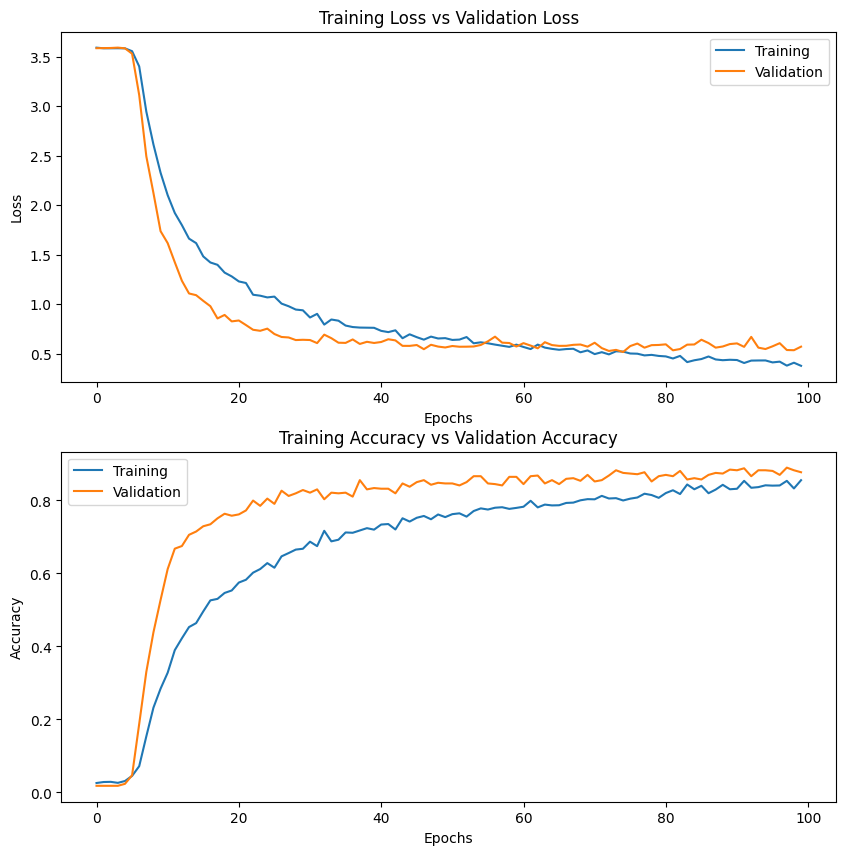

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(['Training', 'Validation'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Training', 'Validation'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

# Autoencoder

In [ ]:
def build_denoising_autoencoder():
    input_img = Input(shape=(180, 180, 1))

    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Model definition
    autoencoder = Model(input_img, x)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder

def build_classifier(encoder, num_classes, learning_rate):
    # Unfreeze the encoder layers
    for layer in encoder.layers:
        layer.trainable = True

    # Get the encoder output
    encoder_output = encoder.output

    # Add fully connected layers
    x = Flatten()(encoder_output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.6)(x)

    # Output layer
    output = Dense(num_classes, activation='softmax')(x)

    # Build the model
    classifier = Model(encoder.input, output)

    # Define optimizer, set learning rate
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model
    classifier.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return classifier


In [ ]:
# Split training/test set for autoencoder with classifier

X_noisy_padded = np.array([pad_spectrogram(spec) for spec in X_noisy])
X_clean_padded = np.array([pad_spectrogram(spec) for spec in X_clean])


# Label processing
label_encoder = LabelEncoder()
labels_processed = label_encoder.fit_transform(labels)

# Normalise
X_noisy_padded = X_noisy_padded.astype('float32') / 255.
X_clean_padded = X_clean_padded.astype('float32') / 255.

# Split data to training set and test set
X_noisy_train, X_noisy_test, X_clean_train, X_clean_test, y_train, y_test = train_test_split(
    X_noisy_padded, X_clean_padded, labels_processed, test_size=0.2, random_state=42, stratify=labels_processed)

# Merge X_noisy_test and X_clean_test
X_test_combined = np.concatenate((X_noisy_test, X_clean_test), axis=0)

# Duplicate y_test so that it matches the new combined test set
y_test_combined = np.concatenate((y_test, y_test), axis=0)


In [ ]:
autoencoder = build_denoising_autoencoder()
autoencoder.summary()

autoencoder.fit(X_noisy_train, X_clean_train, epochs=10, batch_size=32, validation_split=0.2)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 1)]     0         
                                                                 
 conv2d_33 (Conv2D)          (None, 180, 180, 32)      320       
                                                                 
 batch_normalization_28 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_4 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 90, 90, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 90, 90, 64)        1849

In [ ]:
# Adjust learning rate
learning_rate = 0.001

# Use the decoder part of the autoencoder as a feature extractor
decoder_output = autoencoder.layers[-1].output
decoder = Model(inputs=autoencoder.input, outputs=decoder_output)

# Build and compile the model that connects the decoder of the autoencoder with the classifier
classifier = build_classifier(decoder, len(np.unique(y_train)), learning_rate)

# Setup checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('autoencoder_MBPWavs_best_2.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the classifier with the checkpoint callback
history_autoencoder = classifier.fit(X_noisy_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

# Load the best model saved by the checkpoint
best_model = load_model('autoencoder_MBPWavs_best_2.h5')

# Evaluate the best model
score = best_model.evaluate(X_test_combined, y_test_combined)
print('Test accuracy:', score[1])


Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 3.4287 - accuracy: 0.0786
Epoch 1: val_accuracy improved from -inf to 0.41155, saving model to autoencoder_MBPWavs_best_2.h5
35/35 [==============================] - 7s 114ms/step - loss: 3.4287 - accuracy: 0.0786 - val_loss: 2.9611 - val_accuracy: 0.4116
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 2.6312 - accuracy: 0.2791
Epoch 2: val_accuracy improved from 0.41155 to 0.66426, saving model to autoencoder_MBPWavs_best_2.h5
35/35 [==============================] - 4s 107ms/step - loss: 2.6312 - accuracy: 0.2791 - val_loss: 1.9347 - val_accuracy: 0.6643
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 1.8708 - accuracy: 0.4625
Epoch 3: val_accuracy improved from 0.66426 to 0.75451, saving model to autoencoder_MBPWavs_best_2.h5
35/35 [==============================] - 4s 108ms/step - loss: 1.8708 - accuracy: 0.4625 - val_loss: 1.4149 - val_accuracy: 0.7545
Epoch 4/100
35/35 [

Text(0, 0.5, 'Accuracy')

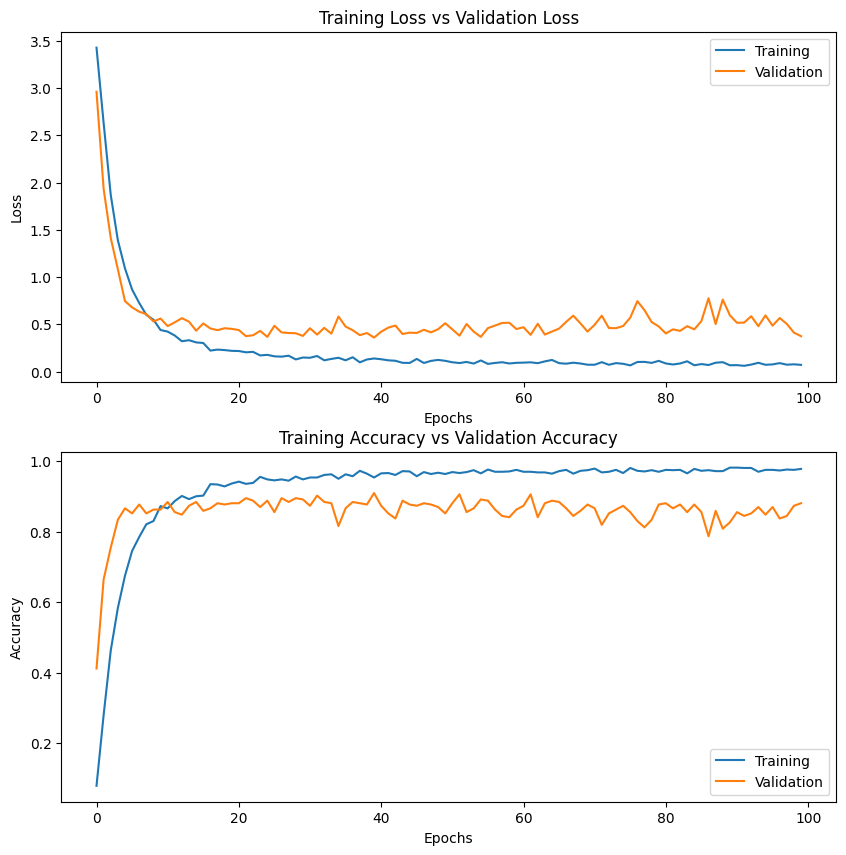

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history_autoencoder.history['loss'])
axs[0].plot(history_autoencoder.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(['Training', 'Validation'])

axs[1].plot(history_autoencoder.history['accuracy'])
axs[1].plot(history_autoencoder.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Training', 'Validation'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")


In [ ]:
# Evaluate the best model
score = best_model.evaluate(X_test_combined, y_test_combined)
print('Test accuracy:', score[1])


22/22 [==============================] - 1s 35ms/step - loss: 0.2316 - accuracy: 0.9277
Test accuracy: 0.9277456402778625
